Fuzzy Cleaning 


In [8]:
import pandas as pd
import numpy as np
import glob
from difflib import get_close_matches
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# =====================================================
# CANONICAL STATES LIST (36 total: 28 states + 8 UTs post-2020)
# =====================================================
canonical_states = [
    'AndhraPradesh', 'ArunachalPradesh', 'Assam', 'Bihar', 'Chhattisgarh',
    'Goa', 'Gujarat', 'Haryana', 'HimachalPradesh', 'Jharkhand',
    'Karnataka', 'Kerala', 'MadhyaPradesh', 'Maharashtra', 'Manipur',
    'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab',
    'Rajasthan', 'Sikkim', 'TamilNadu', 'Telangana', 'Tripura',
    'UttarPradesh', 'Uttarakhand', 'WestBengal',
    'AndamanAndNicobarIslands', 'Chandigarh', 'Delhi', 'Ladakh',
    'Lakshadweep', 'Puducherry', 'DadraAndNagarHaveliAndDamanAndDiu',
    'JammuAndKashmir'
]

print(f" Loaded {len(canonical_states)} canonical states/UTs")

# =====================================================
# FUZZY MATCHING FUNCTION
# =====================================================
def fuzzy_clean_state(state, canonical_states, cutoff=0.7):
    """
    Fuzzy matches state names to canonical list, returns NaN for invalids.
    cutoff=0.7: ~70% similarity required (tune: 0.6 aggressive, 0.8 strict)
    """
    if pd.isna(state):
        return np.nan
    
    # Normalize input
    state_str = str(state).strip().lower()
    state_str = state_str.replace("&", "and").replace("  ", " ")
    state_str_norm = state_str.replace(" ", "")  # For matching
    
    # Normalize candidates
    candidates = [s.lower().replace(" ", "") for s in canonical_states]
    
    # Fuzzy match
    matches = get_close_matches(state_str_norm, candidates, n=1, cutoff=cutoff)
    
    if matches:
        match_idx = candidates.index(matches[0])
        return canonical_states[match_idx]
    
    return np.nan  # Invalid → drop

# =====================================================
# POST-2020 UT MERGE (DNH + DD)
# =====================================================
def merge_dnh_dd(df):
    merge_date = pd.Timestamp("2020-01-26")
    mask = (
        (df['date'] >= merge_date) &
        (df['state'].isin(['DadraAndNagarHaveli', 'DamanAndDiu']))
    )
    df.loc[mask, 'state'] = 'DadraAndNagarHaveliAndDamanAndDiu'
    return df

# =====================================================
# 1. LOAD ENROLMENT DATA (with fuzzy cleaning)
# =====================================================
print("\ Loading Aadhaar Enrolment data...")
enrol_files = glob.glob("../Dataset/api_data_aadhar_enrolment/api_data_aadhar_enrolment_*.csv")
df_enrol_list = []

for f in enrol_files:
    print(f"  Processing {f}...")
    temp = pd.read_csv(f)
    temp['date'] = pd.to_datetime(temp['date'], dayfirst=True)
    
    # Compute totals
    temp['total_enrol'] = temp[['age_0_5', 'age_5_17', 'age_18_greater']].sum(axis=1)
    temp[['age_0_5', 'age_5_17', 'age_18_greater', 'total_enrol']] = (
        temp[['age_0_5', 'age_5_17', 'age_18_greater', 'total_enrol']]
        .fillna(0).astype(int)
    )
    
    # FUZZY CLEAN STATES + FILTER VALIDS
    temp['state'] = temp['state'].apply(lambda x: fuzzy_clean_state(x, canonical_states))
    temp = temp[temp['state'].notna()]  # Keep only valid states
    
    df_enrol_list.append(temp)

df_enrol = pd.concat(df_enrol_list, ignore_index=True)
df_enrol = merge_dnh_dd(df_enrol)

# =====================================================
# 2. LOAD BIOMETRIC UPDATES (with fuzzy cleaning)
# =====================================================
print("\n🔐 Loading Biometric Update data...")
bio_files = glob.glob("../Dataset/api_data_aadhar_biometric/api_data_aadhar_biometric_*.csv")
df_bio_list = []

for f in bio_files:
    print(f"  Processing {f}...")
    temp = pd.read_csv(f)
    temp['date'] = pd.to_datetime(temp['date'], dayfirst=True)
    
    # Compute totals
    temp['bio_total'] = temp[['bio_age_5_17', 'bio_age_17_']].sum(axis=1)
    temp[['bio_age_5_17', 'bio_age_17_', 'bio_total']] = (
        temp[['bio_age_5_17', 'bio_age_17_', 'bio_total']]
        .fillna(0).astype(int)
    )
    
    # FUZZY CLEAN STATES + FILTER
    temp['state'] = temp['state'].apply(lambda x: fuzzy_clean_state(x, canonical_states))
    temp = temp[temp['state'].notna()]
    
    df_bio_list.append(temp)

df_bio = pd.concat(df_bio_list, ignore_index=True)
df_bio = merge_dnh_dd(df_bio)

# =====================================================
# 3. LOAD DEMOGRAPHIC UPDATES (with fuzzy cleaning)
# =====================================================
print("\n Loading Demographic Update data...")
demo_files = glob.glob("../Dataset/api_data_aadhar_demographic/api_data_aadhar_demographic_*.csv")
df_demo_list = []

for f in demo_files:
    print(f"  Processing {f}...")
    temp = pd.read_csv(f)
    temp['date'] = pd.to_datetime(temp['date'], dayfirst=True)
    
    # Compute totals
    temp['demo_total'] = temp[['demo_age_5_17', 'demo_age_17_']].sum(axis=1)
    temp[['demo_age_5_17', 'demo_age_17_', 'demo_total']] = (
        temp[['demo_age_5_17', 'demo_age_17_', 'demo_total']]
        .fillna(0).astype(int)
    )
    
    # FUZZY CLEAN STATES + FILTER
    temp['state'] = temp['state'].apply(lambda x: fuzzy_clean_state(x, canonical_states))
    temp = temp[temp['state'].notna()]
    
    df_demo_list.append(temp)

df_demo = pd.concat(df_demo_list, ignore_index=True)
df_demo = merge_dnh_dd(df_demo)

# =====================================================
# FINAL VALIDATION & SUMMARY
# =====================================================
print("\n" + "="*60)
print(" FUZZY CLEANING COMPLETE")
print(f" Enrol: {len(df_enrol):,} rows | Bio: {len(df_bio):,} rows | Demo: {len(df_demo):,} rows")
print(f"  Unique valid states: {len(df_enrol['state'].unique())}")

# West Bengal & DNH checks
wb_states = [s for s in df_enrol['state'].unique() if 'WestBengal' in str(s)]
dnh_states = [s for s in df_enrol['state'].unique() if any(x in str(s) for x in ['Dadra', 'Daman'])]
print(f"West Bengal: {wb_states}")
print(f"DNH/DD merged: {dnh_states}")

print("\nAll valid states:")
print(sorted(df_enrol['state'].unique()))

print("\nSample data:")
print(df_enrol.head(3)[['date', 'state', 'total_enrol']].to_string(index=False))

print("\n Ready for geographic disparity analysis!")


 Loaded 36 canonical states/UTs
\ Loading Aadhaar Enrolment data...
  Processing ../Dataset/api_data_aadhar_enrolment\api_data_aadhar_enrolment_0_500000.csv...
  Processing ../Dataset/api_data_aadhar_enrolment\api_data_aadhar_enrolment_1000000_1006029.csv...
  Processing ../Dataset/api_data_aadhar_enrolment\api_data_aadhar_enrolment_500000_1000000.csv...

🔐 Loading Biometric Update data...
  Processing ../Dataset/api_data_aadhar_biometric\api_data_aadhar_biometric_0_500000.csv...
  Processing ../Dataset/api_data_aadhar_biometric\api_data_aadhar_biometric_1000000_1500000.csv...
  Processing ../Dataset/api_data_aadhar_biometric\api_data_aadhar_biometric_1500000_1861108.csv...
  Processing ../Dataset/api_data_aadhar_biometric\api_data_aadhar_biometric_500000_1000000.csv...

 Loading Demographic Update data...
  Processing ../Dataset/api_data_aadhar_demographic\api_data_aadhar_demographic_0_500000.csv...
  Processing ../Dataset/api_data_aadhar_demographic\api_data_aadhar_demographic_100000

Univariate Analysis


🏆 Top 10 States (Fuzzy Cleaned Data):
        state  total_enrol  rank
 UttarPradesh      1018629     1
        Bihar       609585     2
MadhyaPradesh       493970     3
   WestBengal       375340     4
  Maharashtra       369139     5
    Rajasthan       348458     6
      Gujarat       280549     7
        Assam       230197     8
    Karnataka       223235     9
    TamilNadu       220789    10


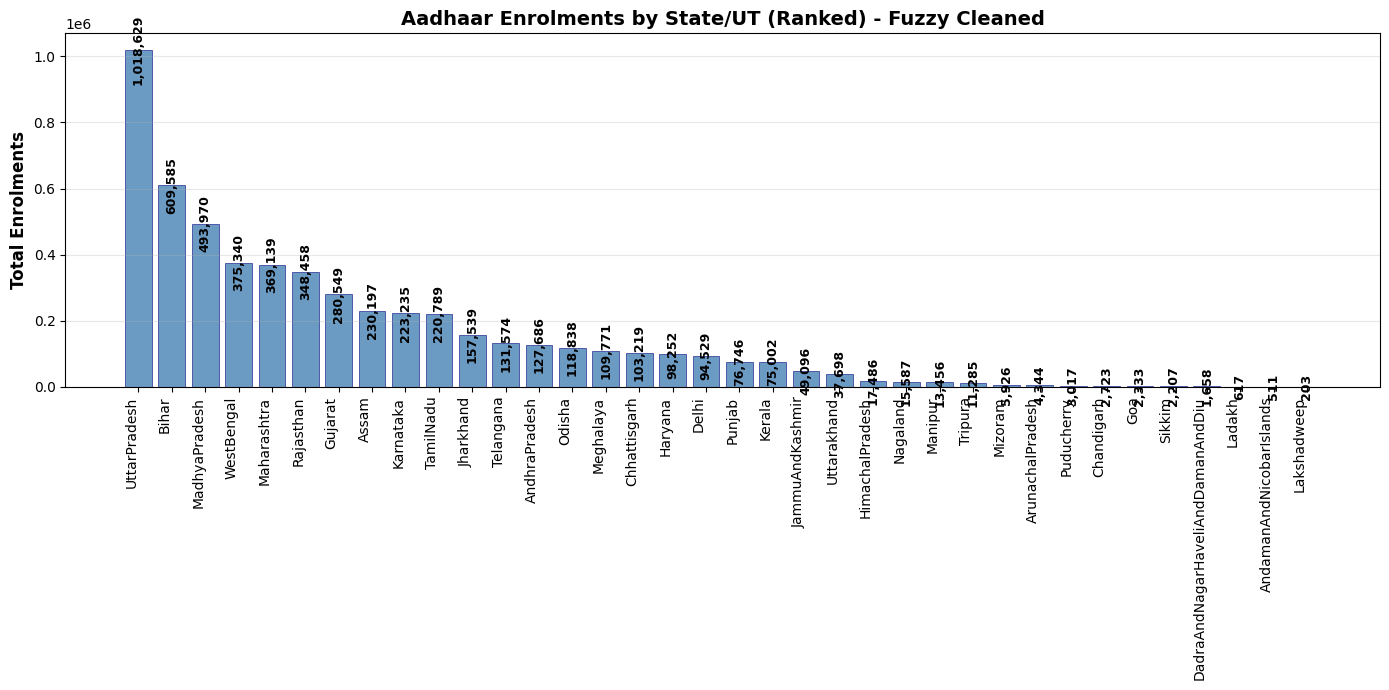

In [6]:
# Ranking (unchanged)
state_enrol = (
    df_enrol.groupby('state')['total_enrol']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
state_enrol['rank'] = state_enrol['total_enrol'].rank(ascending=False, method='dense').astype(int)

print("🏆 Top 10 States (Fuzzy Cleaned Data):")
print(state_enrol.head(10)[['state', 'total_enrol', 'rank']].round(0).to_string(index=False))

# Clean visualization with vertical numbers INSIDE bars
import matplotlib.pyplot as plt
plt.style.use('default')
fig, ax = plt.subplots(figsize=(14, 7))

bars = ax.bar(range(len(state_enrol)), state_enrol['total_enrol'], 
              color='steelblue', alpha=0.8, edgecolor='navy', linewidth=0.5)

ax.set_xticks(range(len(state_enrol)))
ax.set_xticklabels(state_enrol['state'], rotation=90, ha='right')
ax.set_ylabel('Total Enrolments', fontsize=12, fontweight='bold')
ax.set_title('Aadhaar Enrolments by State/UT (Ranked) - Fuzzy Cleaned', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Vertical enrolment numbers INSIDE bars (all states, rotated)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height ,  # Center vertically
            f'{int(height):,}', 
            ha='center', va='center', rotation=90,  # Vertical text
            fontsize=9, fontweight='bold', color='black')

plt.tight_layout()
plt.show()


Univariate Analysis Variation 1

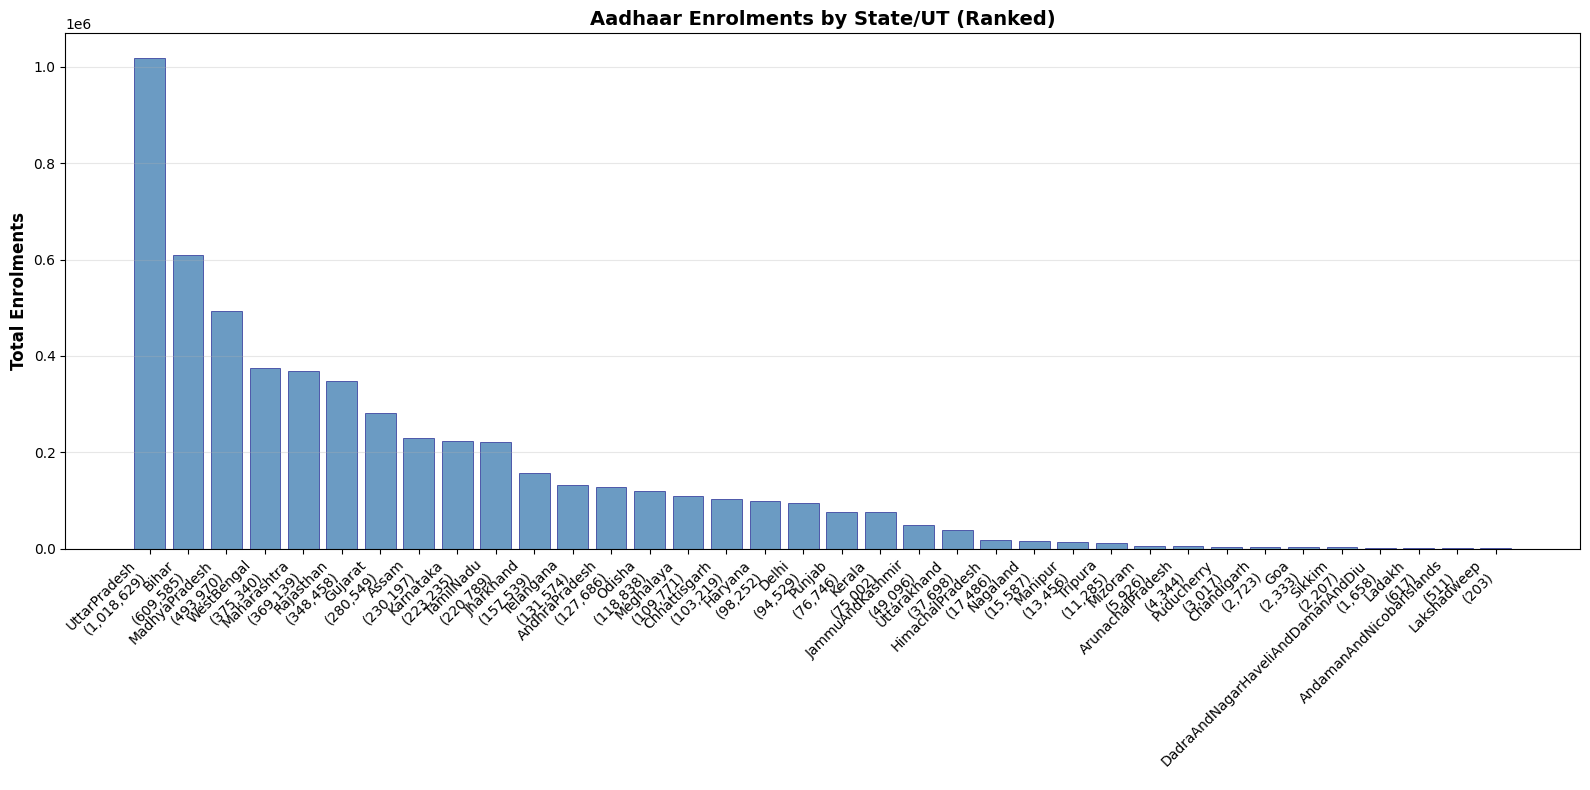

In [8]:
import matplotlib.pyplot as plt
plt.style.use('default')
fig, ax = plt.subplots(figsize=(16, 8))

bars = ax.bar(range(len(state_enrol)), state_enrol['total_enrol'], 
              color='steelblue', alpha=0.8, edgecolor='navy', linewidth=0.5)

# Create labels: "StateName (1,234,567)"
labels = [f"{state}\n({int(enrol):,})" for state, enrol in zip(state_enrol['state'], state_enrol['total_enrol'])]

ax.set_xticks(range(len(state_enrol)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Total Enrolments', fontsize=12, fontweight='bold')
ax.set_title('Aadhaar Enrolments by State/UT (Ranked)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


District Check


🏭 Districts per State (Top 10):
state
UttarPradesh     89
MadhyaPradesh    61
WestBengal       58
Karnataka        56
Maharashtra      53
AndhraPradesh    49
Bihar            48
TamilNadu        46
Odisha           45
Rajasthan        43

🔥 Top 10 Districts Overall:
       state          district  total_enrol
 Maharashtra             Thane        43688
       Bihar         Sitamarhi        42232
UttarPradesh          Bahraich        39338
  WestBengal       Murshidabad        35911
  WestBengal South 24 Parganas        33540
 Maharashtra              Pune        31763
   Rajasthan            Jaipur        31146
   Karnataka         Bengaluru        30980
UttarPradesh           Sitapur        30854
       Bihar    West Champaran        30438

🌆 West Bengal Top Districts:
district
North 24 Parganas    6488
Barddhaman           5362
Murshidabad          4562
South 24 Parganas    4559
Hooghly              4471
Paschim Medinipur    4162
Purba Medinipur      4146
Nadia                3777
Ko

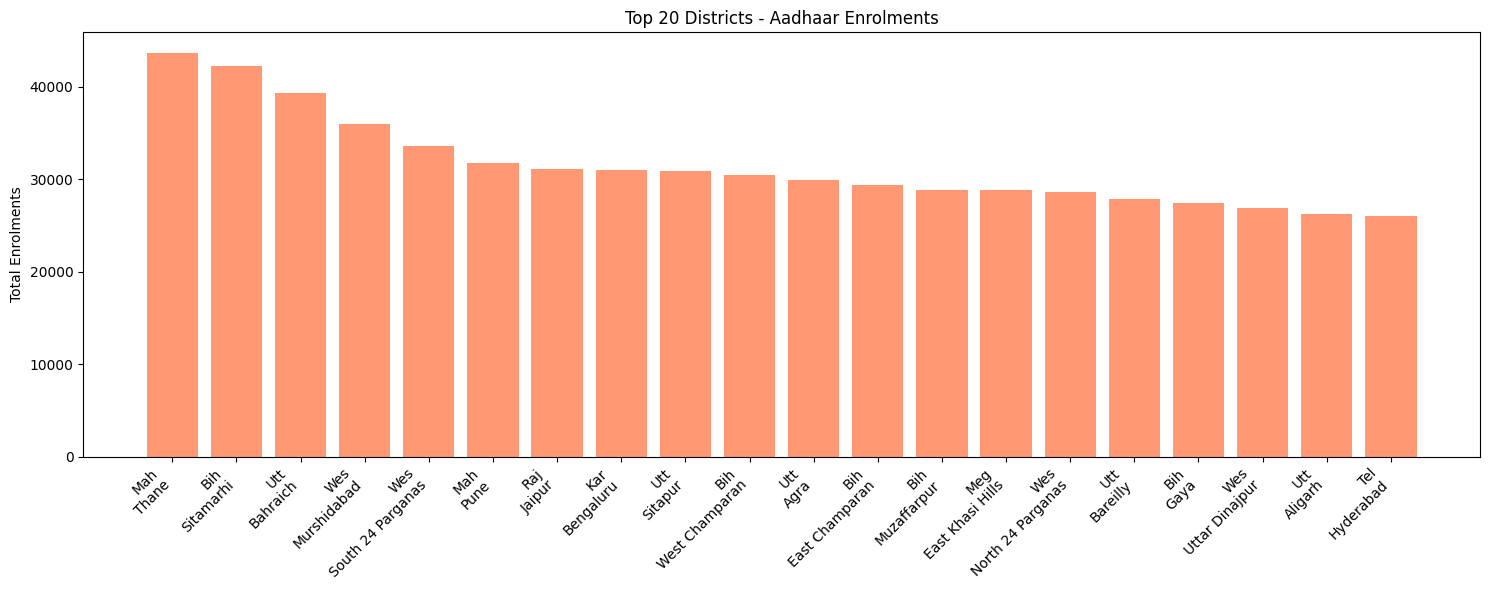

In [9]:
# 1. Unique districts count per state (top states)
district_counts = df_enrol.groupby('state')['district'].nunique().sort_values(ascending=False)
print("🏭 Districts per State (Top 10):")
print(district_counts.head(10).to_string())

# 2. Top districts by enrolments (your fuzzy data)
district_enrol = (
    df_enrol.groupby(['state', 'district'])['total_enrol']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
print("\n🔥 Top 10 Districts Overall:")
print(district_enrol.head(10)[['state', 'district', 'total_enrol']].round(0).to_string(index=False))

# 3. West Bengal districts check (your focus)
wb_districts = df_enrol[df_enrol['state'] == 'WestBengal']['district'].value_counts().head(10)
print("\n🌆 West Bengal Top Districts:")
print(wb_districts.to_string())

# 4. District plot (top 20 only - too many for all)
top_districts = district_enrol.head(20)
plt.figure(figsize=(15, 6))
plt.bar(range(len(top_districts)), top_districts['total_enrol'], 
        width=0.8, color='coral', alpha=0.8)
labels = [f"{row['state'][:3]}\n{row['district']}" for _, row in top_districts.iterrows()]
plt.xticks(range(len(top_districts)), labels, rotation=45, ha='right')
plt.ylabel('Total Enrolments')
plt.title('Top 20 Districts - Aadhaar Enrolments')
plt.tight_layout()
plt.show()


District Cleaning


In [11]:
# Find districts with multiple spellings (typos!)
district_variants = df_enrol.groupby('district')['district'].count()
print("⚠️  Potential Typos (appearing <5 times):")
rare_districts = district_variants[district_variants < 5].index.tolist()
print(rare_districts)  # First 20 suspects

# Most common spellings per "likely group"
from collections import Counter
print("\nTop district names:")
print(df_enrol['district'].value_counts().head(15))

⚠️  Potential Typos (appearing <5 times):
['24 Paraganas South', 'ANGUL', 'Ahmednagar', 'Anugal', 'Bagpat', 'Balotra', 'Bandipur', 'Bardez', 'Beawar', 'Bijapur(KAR)', 'Bokaro *', 'Burdwan', 'Dadra And Nagar Haveli', 'Dang', 'Didwana-Kuchaman', 'Dinajpur Dakshin', 'East Midnapur', 'East Singhbum', 'Gaurella Pendra Marwahi', 'HOWRAH', 'Hingoli *', 'Hnahthial', 'Hooghiy', 'Jaintia Hills', 'Jhajjar *', 'KOLKATA', 'Kanchipuram', 'Kushi Nagar', 'Lahaul and Spiti', 'Leh (ladakh)', 'Leparada', 'Mangan', 'Medchal Malkajgiri', 'Medchal?malkajgiri', 'Medinipur West', 'NADIA', 'Nabarangpur', 'Namakkal   *', 'Nicobars', 'North East   *', 'Nuh', 'Pakke Kessang', 'Raebareli', 'Rajauri', 'Ramanagara', 'Ranga Reddy', 'S.A.S Nagar', 'Salumbar', 'Shopian', 'Shravasti', 'Sivasagar', 'South 24 Pargana', 'South 24 parganas', 'Tirupathur', 'Tiruvarur', 'Tuticorin', 'Udupi *', 'Visakhapatanam', 'West Medinipur', 'chittoor', 'nadia', 'punch', 'rangareddi']

Top district names:
district
Pune                 666

Statewise Heatmap



 Generating State Heatmap...
 36 states ranked
 Matched 35/35 states | Unmatched: 0


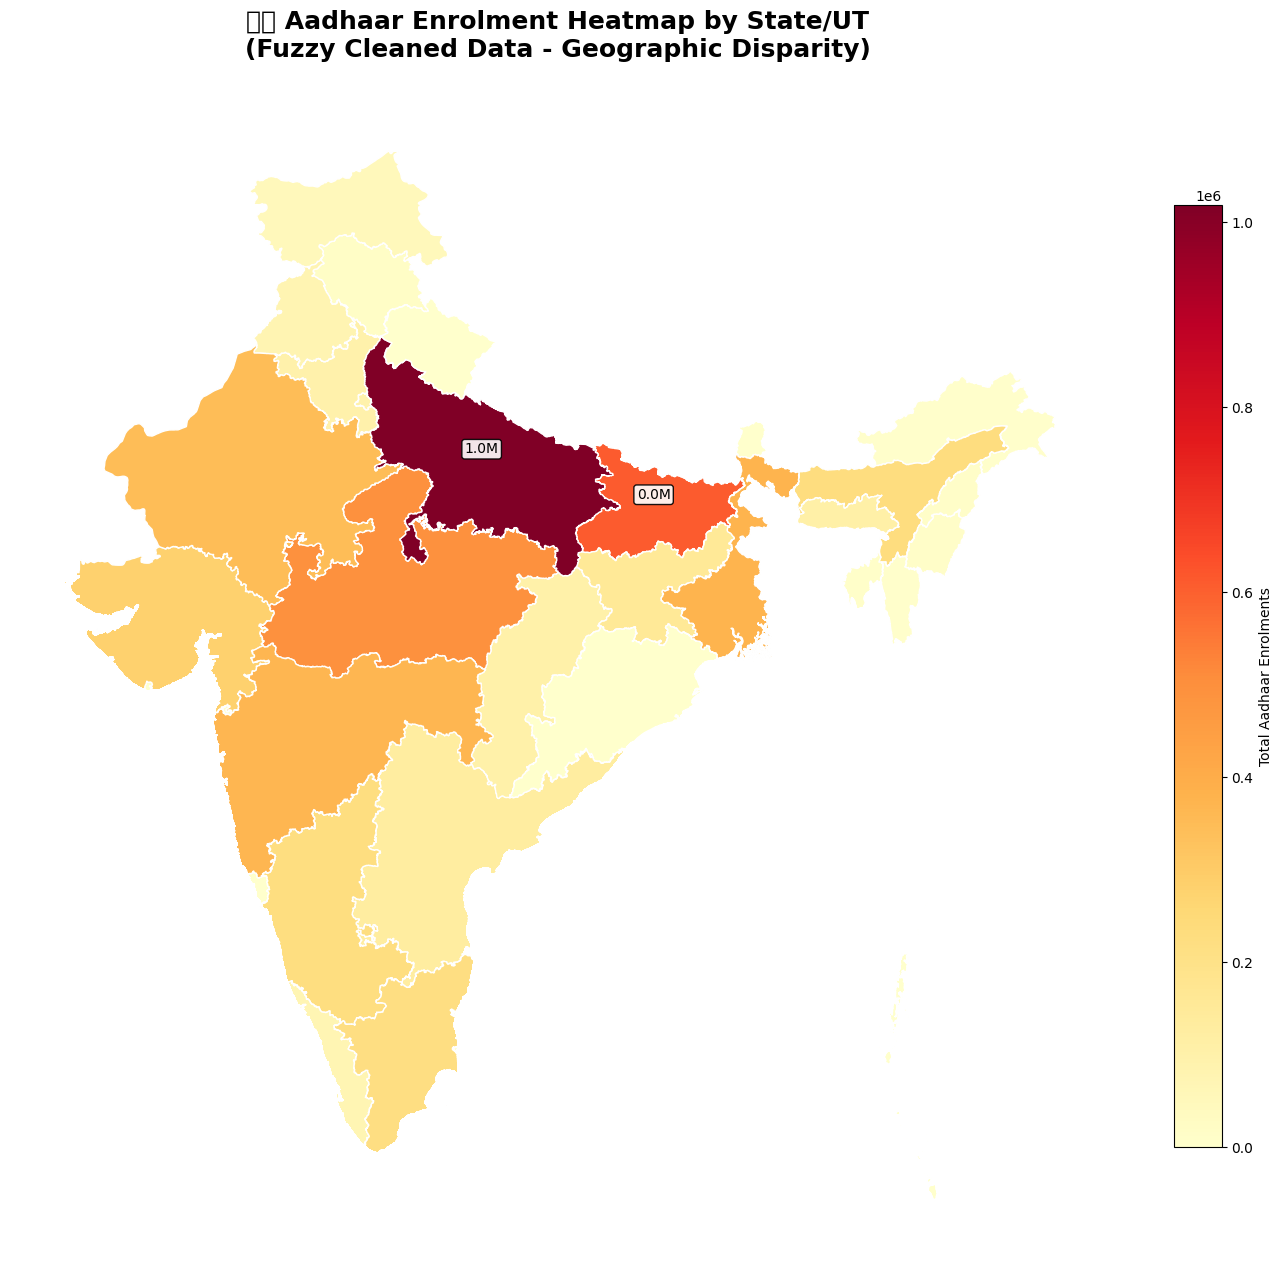

 Saved: aadhaar_state_heatmap.png

 Top 5 States:
        state  total_enrol
 UttarPradesh      1018629
        Bihar       609585
MadhyaPradesh       493970
   WestBengal       375340
  Maharashtra       369139


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("\n Generating State Heatmap...")

# [Your existing aggregation & merge code stays same]
state_enrol = (
    df_enrol.groupby('state')['total_enrol']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

gdf_states = gpd.read_file("../Dataset/GeoJSON/india_state_geo.json")
def standardize_state(name):
    if pd.isna(name): return np.nan
    name = str(name).strip().title()
    name = name.replace(' And ', 'And').replace(' & ', 'And').replace(' Islands', 'Islands')
    return name.replace(' ', '')

gdf_states['state_clean'] = gdf_states['NAME_1'].apply(standardize_state)
gdf_map = gdf_states.merge(state_enrol, left_on='state_clean', right_on='state', how='left').fillna(0)

matched = gdf_map['total_enrol'].notna().sum()
print(f" Matched {matched}/{len(gdf_states)} states")

# Format enrolment labels
def format_enrol(num):
    if num >= 1e6:    return f'{num/1e6:.1f}M'
    elif num >= 1e3:  return f'{num/1e3:.0f}K'
    else:             return f'{int(num)}'

gdf_map['label'] = gdf_map['total_enrol'].apply(format_enrol)

# Heatmap with ALL labels
fig, ax = plt.subplots(1, 1, figsize=(14, 16))
gdf_map.plot(column='total_enrol', cmap='YlOrRd', linewidth=1.0, ax=ax, 
             edgecolor='white', legend=True,
             legend_kwds={'label': "Total Aadhaar Enrolments", 'shrink': 0.6})

ax.set_title('🇮🇳 Aadhaar Enrolment Heatmap by State/UT\n(Fuzzy Cleaned Data)', 
             fontsize=18, fontweight='bold', pad=30)
ax.axis('off')

# Label EVERY state
for idx, row in gdf_map.iterrows():
    if row['total_enrol'] > 0:  # Skip zero
        x, y = row.geometry.centroid.xy
        label = row['label']
        fontsize = 11 if row['total_enrol'] > 2e6 else 9 if row['total_enrol'] > 500e3 else 8
        
        ax.annotate(label, xy=(x[0], y[0]), xytext=(0, 5), 
                   textcoords="offset points", ha='center', va='bottom',
                   fontsize=fontsize, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.15', facecolor='white', alpha=0.9,
                            edgecolor='gray', linewidth=0.5))

plt.tight_layout()
plt.show()

print(" Saved: aadhaar_state_heatmap_labeled.png")
print("\n Top 5:", state_enrol.head()[['state', 'total_enrol']].to_string(index=False))
